In [1]:
import json
import pandas as pd 
import networkx as nx   # To construct graph (network) from records
import networkx.algorithms.components as nxcomp
import numpy as np
from tqdm.notebook import tqdm as tqdm

import matplotlib
matplotlib.rcParams['font.family'] = "serif"
import matplotlib.pyplot as plt
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('lines', markersize=2)


#conda install networkx==2.6.3

# 1. Read data from json file 
### Each row is an observed job transition records as shown below
```
        start	 end	        weight
0	none	president	128628
etc ...
```

### Eg.,: We observed 128,628 transitions from *none* to *president*. 
- *none* means no job was identified from the original biography. 
- *weight* is the total number of observations of this transition 
- You can imagine it is a DIRECTED and WEGITHED graph where:
    - each node is a job title
    - each edge reprsents job transition associated with frequency.

In [2]:
def read_from_json(json_path):
    list_records = []
    with open (json_path, 'r') as f:
        for line in tqdm(f):
            list_records.append(json.loads(line))
    return pd.DataFrame.from_records(list_records)

json_path = "./data/job_graph.json"
pd_edge_list = read_from_json(json_path)
pd_edge_list.head()

,start,end,weight
0,none,president,128628
1,president,none,124247
2,none,owner,171613
3,owner,none,167479
4,none,founder,143970


## 1.1 We may doing some basic analysis here
- Which jobs were mentioned most?
- Which transitions are more frequent?
- Do people move from SDE to senior SDE (promotion) more than the other way (demotion)? (Directionality of transition)
    - Other examples: From student to nurse
- etc ...

# 2: Convert edge list to Graph using NetworkX
- To construct it as a directed weighed graph

## 2.1 Construct directed graph in networkx, see how many nodes/edges/components in this graph(s)

In [3]:
DiG = nx.from_pandas_edgelist(pd_edge_list, 'start', "end", ["weight"], create_using=nx.DiGraph)
print(f'number of nodes: \t\t {DiG.number_of_nodes()}')
print(f'number of edges: \t\t {DiG.number_of_edges()}')
print ( f'Is it weakly-connected?:\t {nxcomp.is_weakly_connected(DiG)}')
num_of_weakly_connect_comps = [len(c) for c in sorted(nx.weakly_connected_components(DiG),key=len, reverse=True)]
print (f'#Nodes in each isolated island: \t {num_of_weakly_connect_comps}')


number of nodes: 		 25033
number of edges: 		 287425
Is it weakly-connected?:	 False
#Nodes in each isolated island: 	 [25021, 2, 2, 2, 2, 2, 2]


## 2.2 What's the neighbors of your favorite job titles?

In [4]:
k_hop = 1

proba_title_1 = "software engineer"
neighbors_1 = list(nx.bfs_tree(DiG, proba_title_1, depth_limit = k_hop).nodes())[:5]
print (f"Number of neighbors of {proba_title_1}: \t {len(neighbors_1)}")
print(f"{neighbors_1}")

proba_title_2 = "research scholar"
neighbors_2 = list(nx.bfs_tree(DiG, proba_title_2, depth_limit = k_hop).nodes())[:5]
print (f"Number of neighbors of {proba_title_2}: \t {len(neighbors_2)}")
print(f"{neighbors_2}")

neighbors = set (neighbors_1 + neighbors_2)
print (neighbors)

Number of neighbors of software engineer: 	 5
['software engineer', 'senior software engineer', 'none', 'research scholar', 'full stack developer']
Number of neighbors of research scholar: 	 5
['research scholar', 'none', 'secretary', 'postdoctoral fellow', 'senior research fellow']
{'secretary', 'senior research fellow', 'none', 'full stack developer', 'research scholar', 'software engineer', 'senior software engineer', 'postdoctoral fellow'}


## 2.3 Drawing the subgraph of the neighbors. Can you see local communities?

(-1.8049303711274007, 1.7090291437693113)

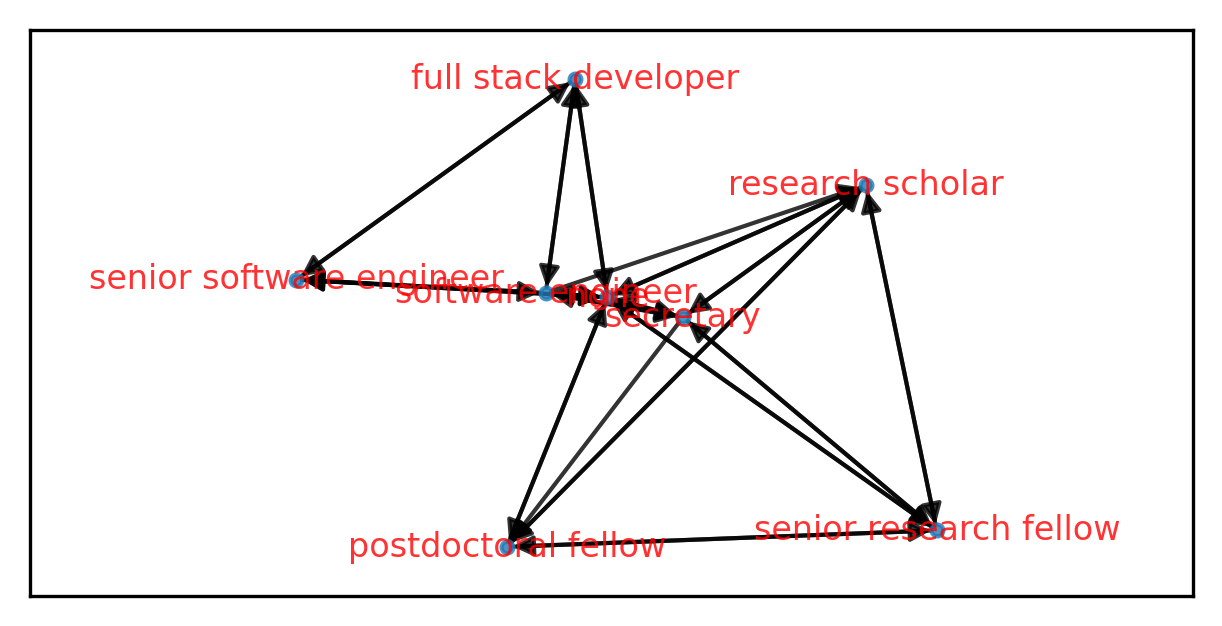

In [8]:
SubDiG = DiG.subgraph(neighbors).copy()
fig = plt.figure(figsize=(5,2.5), dpi = 300)
nx.draw_networkx(SubDiG, pos=nx.spring_layout(SubDiG, seed = 8), node_size = SMALL_SIZE, font_size = SMALL_SIZE, font_color = 'red', alpha = 0.8, )
axis = fig.gca()
axis.set_xlim([1.5*x for x in axis.get_xlim()])
